# Movie Data Analysis Project 

##### Students: William Bennett, Alex Karadjov

##### Instructor: David Elliot

##### Active Project Dates: May 8th - 12th

<img src='movie-producer-1000x600.jpg' width="600" height="400">


## Business Understanding
#### Business Question
Your company has now seen all the other big companies creating original video content. Your companies board have _decided to create a new movie studio_, but they don’t know anything about _creating movies._ 
<br>
#### Business Proposal
###### We are _charged_ with exploring what types of films are currently doing the _**best at the box office**._

###### We then _translate_ those findings into _undstandable and logistical_ formats 

###### All inorder to give _an insightful _**conclusion**_ on what type of films are the _**best to be creating**._


##### The _best_  at the box office. 
What does **best** mean:
- money
- rating, won’t line pockets
- consistency


_**While keeping these points in mind**_
<br>
<br>
We have decieded these **columns** below will be used directly to _aid us in determining our **business proposal**_**;**
- Gross 
- Avgerage Rating 
- Number of Votes 
- Run Time Minutes
- Region
- Genre

#### Imports

Importing necessary libraries;

In [1]:
import pandas as pd
import numpy as np # used to find correlation coefficient
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd # to compare multiple samples
import statsmodels.api as sm # We use this to perform a linear regression



### Understanding the Data
What are we looking at?

#### Connections
Connecting Data to Sqlite;

In [2]:
# Switch these depending on your OS after you unzip the im.db folter
# conn = sqlite3.connect('zippedData/im.db') #Mac
conn = sqlite3.connect('zippedData/im.db/im.db') #PC

Viewing the Data Tables;

In [3]:
schema_df = pd.read_sql("""

SELECT *
FROM sqlite_master

""", conn)

schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
pd.read_sql("""

SELECT *
FROM movie_basics b
limit 3

""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


In [5]:
pd.read_sql("""

SELECT *
FROM movie_ratings
limit 3

""", conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20


#### Creating DataFrames;

IMDB Movie Data Frame;

In [6]:
df_imdb = pd.read_sql("""

SELECT b.movie_id
       ,b.primary_title
       ,b.original_title
       ,b.start_year
       ,b.runtime_minutes
       ,b.genres
       ,r.averagerating
       ,r.numvotes
       ,a.region
FROM movie_basics b
join movie_ratings r on r.movie_id = b.movie_id
left join movie_akas a on a.movie_id = b.movie_id 

""", conn)

In [7]:
df_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


<br>
Box Office Mojo Movie Data Frame
<br>

In [8]:
df_mg = pd.read_csv('zippedData/bom.movie_gross.csv.gz', sep=',')

In [9]:
df_mg.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Data Preperation
Our main focuses while cleaning will be;

Gross based;
* Remove non US dollar value column
    - Change Null Values to -99999 to create visible outlier

Avgerage Rating based;
* Remove rows from the column avgeragerating if the column numvotes has a row with less than 30 votes
    - drop null values for both columns

Genre based;
* Seperate multiple genre movies
    - drop null values


Run Time Minutes based;
* Handle outliers with long runtimes
    - drop null values


Null Values based;
* Drop and replace based on significance for all significant data used

Column Names based;
* Cleaning the names to the same format


#### Cleaning the Data Frames with Significant Information

<br>
IMBD Data Frame;
<br>
- Clean the column names;

In [10]:
[c.replace("_", "").strip() for c in df_imdb.columns]

['movieid',
 'primarytitle',
 'originaltitle',
 'startyear',
 'runtimeminutes',
 'genres',
 'averagerating',
 'numvotes',
 'region']

In [11]:
df_imdb = df_imdb.rename(columns = dict(zip(df_imdb.columns, [c.replace("_", "").strip() for c in df_imdb.columns])))

In [12]:
df_imdb.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


In [13]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266085 entries, 0 to 266084
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movieid         266085 non-null  object 
 1   primarytitle    266085 non-null  object 
 2   originaltitle   266085 non-null  object 
 3   startyear       266085 non-null  int64  
 4   runtimeminutes  253959 non-null  float64
 5   genres          264736 non-null  object 
 6   averagerating   266085 non-null  float64
 7   numvotes        266085 non-null  int64  
 8   region          218341 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 18.3+ MB


<br>
Box Office Mojo Movie Gross Data Frame
<br>
- Cleaning the column names

In [14]:
df_mg = df_mg.rename(columns = dict(zip(df_mg.columns, [c.replace("_", "").strip() for c in df_mg.columns])))

In [15]:
df_mg[['primarytitle', 'startyear']] = df_mg[['title', 'year']]

In [16]:
df_mg.head()

,title,studio,domesticgross,foreigngross,year,primarytitle,startyear
0,Toy Story 3,BV,415000000.0,652000000,2010,Toy Story 3,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010,Alice in Wonderland (2010),2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,Harry Potter and the Deathly Hallows Part 1,2010
3,Inception,WB,292600000.0,535700000,2010,Inception,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,Shrek Forever After,2010


In [17]:
df_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          3387 non-null   object 
 1   studio         3382 non-null   object 
 2   domesticgross  3359 non-null   float64
 3   foreigngross   2037 non-null   object 
 4   year           3387 non-null   int64  
 5   primarytitle   3387 non-null   object 
 6   startyear      3387 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 185.4+ KB


#### Creating a Final Data Frame by Combining the Two Data sets 
Final Data Cleaning

In [18]:
df_clean = df_imdb

In [19]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


In [20]:
# combining the two datasets into a new dataframe
df_clean = pd.merge(df_clean, df_mg, how='left', on=['primarytitle','startyear'])

In [21]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,NaN,NaN
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN


##### Region Cleaning
Dropping null values;

In [22]:
df_clean['region'].isnull().sum()

47744

In [23]:
df_clean = df_clean.dropna(subset=['region'])

<br>
Checking;

In [24]:
df_clean['region'].isnull().sum()

0


##### Gross Cleaning
Creating a new column for total_gross by combining the domesticgross column and foreigngross column;
<br>

In [25]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_clean['domesticgross'] = df_clean['domesticgross'].apply(pd.to_numeric, errors = 'coerce').dropna().astype(float)
df_clean['foreigngross'] = df_clean['foreigngross'].apply(pd.to_numeric, errors = 'coerce').dropna().astype(float)

df_clean['totalgross'] = df_clean['domesticgross'] + df_clean['foreigngross']

df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year,totalgross
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,NaN,NaN,NaN,NaN,NaN


<br>
Dropping any null values in the total_gross column;

In [29]:
df_clean['totalgross'].isnull().sum()

186972

In [30]:
df_clean['totalgross'].fillna(-999999, inplace=True)

In [32]:
df_clean['totalgross'].isnull().sum()

0

<br>
Checking;

In [33]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year,totalgross
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,NaN,NaN,NaN,NaN,-999999.0


<br>
<br>

Since the **total_gross** column now exists we can drop the **domesticgross** and **foreigngross** columns for a cleaner data set;

In [34]:
df_clean = df_clean.drop('domesticgross', axis = 1)

In [35]:
df_clean = df_clean.drop('foreigngross', axis = 1)

<br>
Checking;

In [36]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,year,totalgross
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,NaN,NaN,-999999.0


<br>
Because different regions will have different currency affecting our data in a negative way we will be focusing on data that is specifically from the US so we will not have to worry about currency exchanges;
<br>

In [88]:
df_clean['totalgrossusa'] = np.where(df_clean['region']=="US", df_clean['totalgross'] , 'dif_curency')

<br>
Checking;

In [89]:
df_clean['totalgrossusa'].value_counts()

dif_curency     159651
-999999.0        17366
32400000.0          15
752600000.0          9
1123800000.0         7
                 ...  
27700000.0           1
611200.0             1
348300000.0          1
331300000.0          1
543900000.0          1
Name: totalgrossusa, Length: 928, dtype: int64

##### Genre Cleaning
Splitting up the Genres into new columns for multiple genre movies and dropping Null Values;

In [39]:
df_clean = df_clean.dropna(subset=['genres'])

<br>

In [40]:
df_clean['genres'].str.rsplit(",", expand=True)

,0,1,2
1,Action,Crime,Drama
2,Action,Crime,Drama
3,Action,Crime,Drama
4,Action,Crime,Drama
7,Biography,Drama,None
...,...,...,...
266062,Comedy,Horror,None
266068,Drama,None,None
266069,Drama,None,None
266077,Drama,None,None


In [67]:
df_clean[['genre1', 'genre2', 'genre3']] = df_clean['genres'].str.rsplit(",", expand=True)

<br>
Checking;

In [42]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,year,totalgross,totalgrossusa,genre_1,genre_2,genre_3
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,NaN,NaN,-999999.0,dif_curency,Biography,Drama,None


#### Review Cleaning
<br>
Dropping null values and movies with less than 30 reviews from data frame;

In [43]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,year,totalgross,totalgrossusa,genre_1,genre_2,genre_3
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,dif_curency,Action,Crime,Drama
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,NaN,NaN,-999999.0,dif_curency,Biography,Drama,None


In [44]:
df_clean['numvotes'].min()

5

In [45]:
df_clean = df_clean[df_clean['numvotes'] >= 30]

<br>
Checking;

In [46]:
df_clean['numvotes'].min()

30

In [47]:
df_clean = df_clean.dropna(subset=['numvotes'])

In [48]:
df_clean['numvotes'].isnull().sum()

0

In [82]:
df_clean.head(50)

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,...,year,totalgross,totalgrossusa,genre_1,genre_2,genre_3,genre1,genre2,genre3,runtimecategory
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,...,NaN,-999999.0,dif_curency,Action,Crime,Drama,Action,Crime,Drama,Normal Film (long)
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,...,NaN,-999999.0,dif_curency,Action,Crime,Drama,Action,Crime,Drama,Normal Film (long)
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,...,NaN,-999999.0,dif_curency,Action,Crime,Drama,Action,Crime,Drama,Normal Film (long)
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,...,NaN,-999999.0,dif_curency,Action,Crime,Drama,Action,Crime,Drama,Normal Film (long)
7,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,IN,NaN,...,NaN,-999999.0,dif_curency,Biography,Drama,None,Biography,Drama,None,Normal Film (optimal)
8,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,XWW,NaN,...,NaN,-999999.0,dif_curency,Biography,Drama,None,Biography,Drama,None,Normal Film (optimal)
10,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,AR,NaN,...,NaN,-999999.0,dif_curency,Drama,None,None,Drama,None,None,Normal Film (long)
11,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,BR,NaN,...,NaN,-999999.0,dif_curency,Drama,None,None,Drama,None,None,Normal Film (long)
12,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,DE,NaN,...,NaN,-999999.0,dif_curency,Drama,None,None,Drama,None,None,Normal Film (long)
13,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,ES,NaN,...,NaN,-999999.0,dif_curency,Drama,None,None,Drama,None,None,Normal Film (long)



##### Runtime Cleaning
<br>
Handling outliers that have significantly longer runtimes than most

In [50]:
df_clean['runtimeminutes'].describe()

count    178805.00000
mean        102.24336
std          39.60074
min           8.00000
25%          90.00000
50%          99.00000
75%         112.00000
max       14400.00000
Name: runtimeminutes, dtype: float64

When checking **outliers** with _.describe()_ 
<br>
<br>
We can observe the **longest** runtimeminutes value is **14400.000000** minutes... thats a very long movie
<br>
<br>
Using a seaborn blox plot we can see the _spread of the **outliers**;_

<br>
Checking;

C:\Users\16047\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='runtimeminutes'>

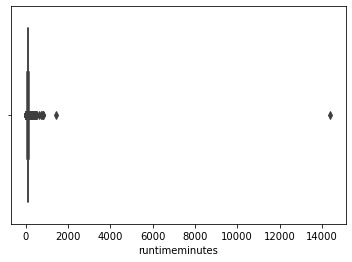

In [51]:
sns.boxplot(df_clean['runtimeminutes'])

<br>
After looking at this boxplot _we can conqure that_ we will **drop** any movies that are **longer than 333.0 minutes** for a cleaner data set
<br>
<br>

In [52]:
df_clean = df_clean[df_clean['runtimeminutes'] <= 333.0]

<br>
Checking;

In [53]:
df_clean['runtimeminutes'].describe()

count    178764.000000
mean        102.077113
std          19.551550
min           8.000000
25%          90.000000
50%          99.000000
75%         112.000000
max         325.000000
Name: runtimeminutes, dtype: float64

C:\Users\16047\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='runtimeminutes'>

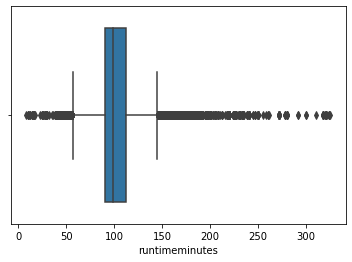

In [54]:
sns.boxplot(df_clean['runtimeminutes'])

We can now actually see something from this box chart, there are still many outliers but after research we are able o conclude 333 minutes will include up to 97% of our data. 

# Exploratory Data Analysis
What we found:
- Data freshness, years are from 2010-2019. This is slightly stale.
- Explore the top genres and genre combinations
- Explore runtime
- Explore how ratings is related to gross


In [56]:
# Update the revenue filter to only include good values
has_rev_filter = df_clean['totalgross'] != -999999

### Data Freshness

In [57]:
df_imdb['startyear'].describe()

count    266085.000000
mean       2014.163876
std           2.594150
min        2010.000000
25%        2012.000000
50%        2014.000000
75%        2016.000000
max        2019.000000
Name: startyear, dtype: float64

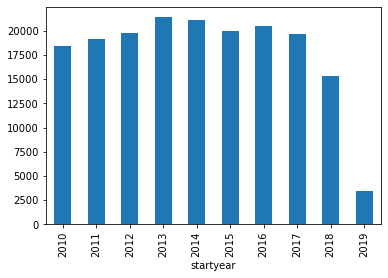

In [58]:
# Check how much data we have for each year
df_clean.groupby('startyear')['movieid'].count().plot.bar();

**Observations**
- This data is from a range of years so we may want to adjust any money values for inflation
- This data does not include the COVID-19 pandemic so any recommendations would need to take that into account

### Genres

In [59]:
# First let's find the top genres
top_genres_combos = list(df_clean.groupby('genres').count().reset_index().nlargest(10, columns='movieid')['genres'])
top_genres_combos

['Drama',
 'Comedy',
 'Documentary',
 'Comedy,Drama',
 'Drama,Romance',
 'Comedy,Drama,Romance',
 'Adventure,Animation,Comedy',
 'Comedy,Romance',
 'Horror',
 'Drama,Thriller']

In [60]:
# Create a filter for only top genres
top_genre_combos_filter = df_clean['genres'].isin(top_genres_combos)

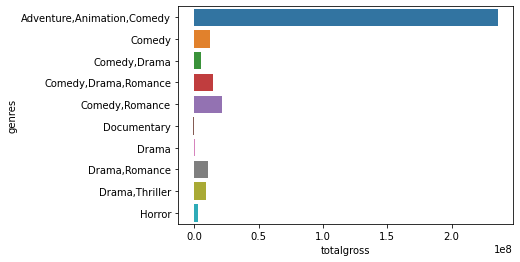

In [61]:
# Compare total gross revenue for top genres
top_genre_combos = df_clean[top_genre_combos_filter].groupby('genres')['totalgross'].mean().reset_index()
sns.barplot(data=top_genre_combos, x='totalgross', y='genres');

**Observations**
- There are similar combinations (Comedy vs. Comedy,Drama) so we may want to split those out
- One category is much higher than the others, it turned out the there were different currencies here so we needed to split out USD only

Are the differences signficiant however, let's find out?

In [62]:
print(pairwise_tukeyhsd(df_clean[top_genre_combos_filter]['totalgross'], df_clean[top_genre_combos_filter]['genres']))

                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                             
          group1                  group2            meandiff    p-adj       lower           upper      reject
-------------------------------------------------------------------------------------------------------------
Adventure,Animation,Comedy               Comedy -223146589.5217  0.001 -228202425.0885 -218090753.9549   True
Adventure,Animation,Comedy         Comedy,Drama -230119227.7409  0.001 -235286298.6547  -224952156.827   True
Adventure,Animation,Comedy Comedy,Drama,Romance -221314920.1809  0.001 -227020900.0814 -215608940.2804   True
Adventure,Animation,Comedy       Comedy,Romance -213756719.9321  0.001 -219756594.3566 -207756845.5076   True
Adventure,Animation,Comedy          Documentary -236423432.8444  0.001 -241524586.8268  -231322278.862   True
Adventure,Animation,Comedy                Drama -235141830.1993  0.001  -239682238.558 -230601421.8406   True
Adventure,

**Observations**
- [TBD]

### Runtime
What we found:
- There were a significant number of outliers
- There were movies with 5k runtime minutes, which is way too long for a movie
- We will want to categorize these to see if there is an optimal length

In [63]:
# Explore the column
df_clean['runtimeminutes'].describe()

count    178764.000000
mean        102.077113
std          19.551550
min           8.000000
25%          90.000000
50%          99.000000
75%         112.000000
max         325.000000
Name: runtimeminutes, dtype: float64

In [64]:
# Let's explore the runtime data
sns.boxplot(data=df_clean['runtimeminutes']);

KeyError: 0

# Modeling
What we will be doing:
- Categorize movies by genre (split out the genre string)
- Categorize movies based on runtime

### Genre

The current state of our data is:
- movie1: genre1, genre2, genre3

We want to change that to:
- genre1: movie1
- genre2: movie1
- genre3: movie1

This will let us find the average gross revenue by individual genres.

*Note: This approach does double count movies, we're handling this by also comparing the genre combinations*

In [68]:
# Let's start by creating a new dataframe that counts movies for each genre
temp_1 = df_clean[has_rev_filter][['totalgross','genre1']]
temp_2 = df_clean[has_rev_filter][['totalgross','genre2']]
temp_3 = df_clean[has_rev_filter][['totalgross','genre3']]

temp_1.rename(columns={"genre1": "genre"}, inplace=True)
temp_2.rename(columns={"genre2": "genre"}, inplace=True)
temp_3.rename(columns={"genre3": "genre"}, inplace=True)

genre_revenue = temp_1.append(temp_2).append(temp_3).dropna()
genre_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82969 entries, 152 to 257150
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   totalgross  82969 non-null  float64
 1   genre       82969 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [69]:
# Let's check value counts
genre_revenue['genre'].value_counts()

Drama          13886
Comedy         11815
Action         10609
Adventure      10163
Thriller        5374
Crime           4482
Romance         4190
Animation       3310
Sci-Fi          3006
Fantasy         2905
Biography       2882
Horror          2764
Mystery         2560
Family          1916
History         1070
Music            740
Sport            445
Documentary      386
War              174
Western          174
Musical          118
Name: genre, dtype: int64

In [70]:
# Let's check stats for the new dataframe
genre_revenue.groupby('genre').describe()

totalgross                                                      \
                 count          mean           std        min          25%   
genre                                                                        
Action         10609.0  3.110103e+08  3.158366e+08   369500.0   72600000.0   
Adventure      10163.0  4.052129e+08  3.379590e+08   624000.0  125811000.0   
Animation       3310.0  4.239941e+08  3.222537e+08  1301500.0  147500000.0   
Biography       2882.0  1.117756e+08  1.456223e+08   608000.0   22200000.0   
Comedy         11815.0  1.952488e+08  2.403139e+08   104500.0   46100000.0   
Crime           4482.0  1.083878e+08  1.280153e+08    55600.0   30733250.0   
Documentary      386.0  1.402893e+07  2.031950e+07    49400.0    1828000.0   
Drama          13886.0  1.072551e+08  1.370806e+08    55100.0   21100000.0   
Family          1916.0  2.140266e+08  2.139373e+08   832300.0   60237000.0   
Fantasy         2905.0  3.116925e+08  3.326924e+08   346700.0   74700000.0   
History         1070.0  1.149242e+08  1.207442e+08   342300.0   16000000.0   
Horror          2764.0  1.221619e+08  1.312807e+08   369500.0   38200000.0   
Music            740.0  1.284352e+08  1.998593e+08   569000.0   20510000.0   
Musical          118.0  2.309113e+08  1.788184e+08   193300.0   59400000.0   
Mystery         2560.0  1.280289e+08  1.266372e+08   293100.0   33200000.0   
Romance         4190.0  8.643692e+07  9.376711e+07   104500.0   25300000.0   
Sci-Fi          3006.0  4.265206e+08  3.621175e+08  1756000.0  127200000.0   
Sport            445.0  7.566333e+07  6.180117e+07  1701700.0   23100000.0   
Thriller        5374.0  1.763870e+08  2.214144e+08    55100.0   37900000.0   
War              174.0  7.239984e+07  6.810333e+07   228000.0    3800000.0   
Western          174.0  2.095810e+08  1.488354e+08   321100.0   87200000.0   

                                                     
                     50%          75%           max  
genre                                                
Action       177200000.0  467400000.0  1.405400e+09  
Adventure    303000000.0  644600000.0  1.405400e+09  
Animation    351300000.0  591800000.0  1.276400e+09  
Biography     60068500.0  140300000.0  9.036000e+08  
Comedy       106200000.0  236400000.0  1.276400e+09  
Crime         69000000.0  154000000.0  7.887000e+08  
Documentary    5400000.0   17110999.0  9.900000e+07  
Drama         61000000.0  135500000.0  9.036000e+08  
Family       150200000.0  299400000.0  1.021100e+09  
Fantasy      151100000.0  449300000.0  1.332600e+09  
History       67800000.0  177600000.0  5.252000e+08  
Horror        85400000.0  146400000.0  8.071000e+08  
Music         73300000.0  115300000.0  9.036000e+08  
Musical       89500000.0  425000000.0  4.350000e+08  
Mystery       85400000.0  167800000.0  5.868000e+08  
Romance       59300000.0  119500000.0  5.710000e+08  
Sci-Fi       348300000.0  668000000.0  1.405400e+09  
Sport         49000000.0  110200000.0  2.140000e+08  
Thriller      89400000.0  218800000.0  1.108600e+09  
War           76600000.0  115000000.0  1.776000e+08  
Western      252200000.0  260500000.0  4.254000e+08

In [71]:
# Create data for plotting
genre_revenue_data = genre_revenue.groupby('genre').mean().reset_index().sort_values(by='totalgross', ascending=False)
genre_revenue_data.head()

,genre,totalgross
16,Sci-Fi,4.265206e+08
2,Animation,4.239941e+08
1,Adventure,4.052129e+08
9,Fantasy,3.116925e+08
0,Action,3.110103e+08


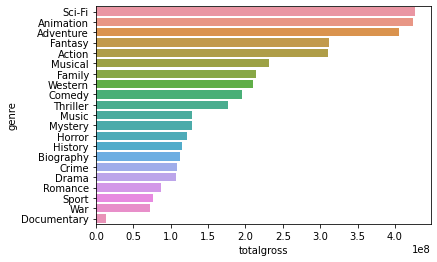

In [72]:
sns.barplot(data=genre_revenue_data, x='totalgross', y='genre');

In [73]:
# Check the significance
print(pairwise_tukeyhsd(genre_revenue['totalgross'], genre_revenue['genre']))

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
   group1      group2       meandiff    p-adj       lower           upper      reject
-------------------------------------------------------------------------------------
     Action   Adventure   94202590.1177  0.001   82176662.0337  106228518.2016   True
     Action   Animation  112983790.1076  0.001   95734134.4989  130233445.7164   True
     Action   Biography -199234736.4627  0.001 -217434489.3447 -181034983.5807   True
     Action      Comedy -115761455.0272  0.001 -127350031.4095  -104172878.645   True
     Action       Crime -202622470.0245  0.001 -218057713.7576 -187187226.2914   True
     Action Documentary -296981367.9868  0.001 -341875995.5138 -252086740.4599   True
     Action       Drama -203755209.3412  0.001 -214927456.8812 -192582961.8012   True
     Action      Family  -96983658.1102  0.001  -118490741.704  -75476574.5164   True
     Action     Fantasy     682229.3093    0.9  -17460

**Observations**
- [TBD]

### Runtime

We need to start feature engineering for runtime. Instead of trying to optimize runtime for gross revenue we will instead categorize runtime and compare revenue among the newly created categories

In [74]:
# Create a function to categorize runtimes
def film_categorization(runtime):
    """
    Input: the movie runtime (float)
    Output: the movie runtime category (string)
    """
    movie_category = ''
    if runtime < 40: # The movie industry considers this a short film
        movie_category =  'Short Film'
    elif runtime < 96: # This is outside the common hollywood length
        movie_category =  'Normal Film (short)'
    elif (runtime >= 96) and (runtime <= 120): # 50% of hollywood movies are in this range
        movie_category =  'Normal Film (optimal)'
    elif (runtime > 120): # These are longer than the common range
        movie_category =  'Normal Film (long)'
    else: # if no runtime exists
        movie_category =  'No Runtime'
    return movie_category

In [75]:
# Add a new column categorizing the runtime
df_clean['runtimecategory'] = df_clean['runtimeminutes'].apply(film_categorization)
df_clean['runtimecategory'].value_counts()

Normal Film (optimal)    77773
Normal Film (short)      74940
Normal Film (long)       26001
Short Film                  50
Name: runtimecategory, dtype: int64

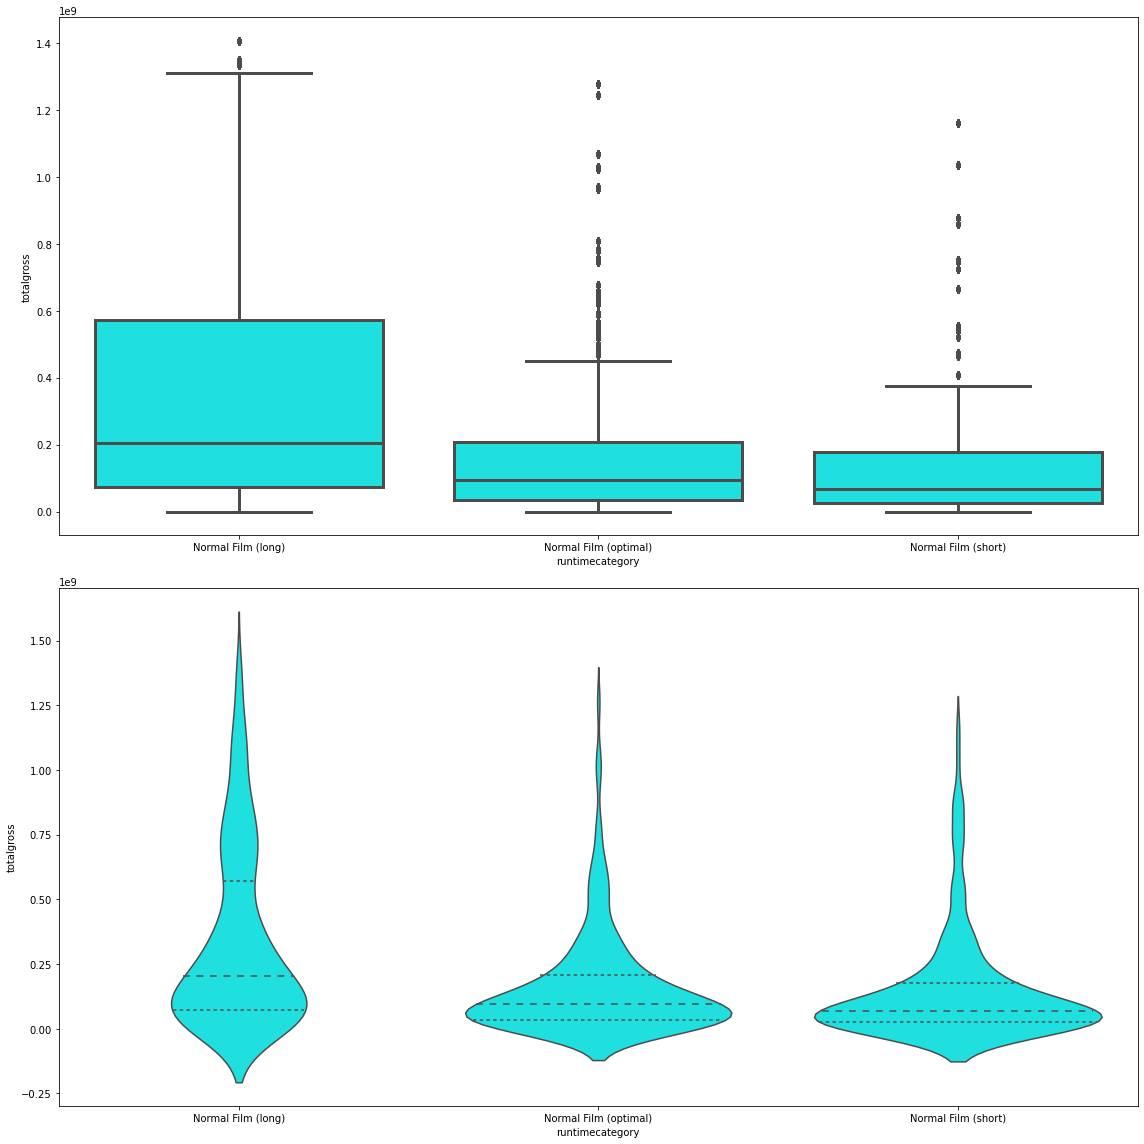

In [77]:
# Visualize the distributions
fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(16, 16))

sns.boxplot(
    x="runtimecategory",
    y="totalgross",
    data=df_clean[has_rev_filter],
    ax=ax0,
    color='aqua', 
    linewidth=3
)



sns.violinplot(
    x="runtimecategory",
    y="totalgross",
    data=df_clean[has_rev_filter],
    ax=ax1,
    color='aqua',
    inner="quartile",  # Seeing the mean and quartiles
    bw=.3              # How much smoothing do we use
)

plt.tight_layout();

In [78]:
# Check for significant differences between the four categories
print(pairwise_tukeyhsd(df_clean[has_rev_filter]['totalgross'], df_clean[has_rev_filter]['runtimecategory']))

                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
        group1                group2            meandiff    p-adj      lower           upper      reject
--------------------------------------------------------------------------------------------------------
   Normal Film (long) Normal Film (optimal) -176617452.4555 0.001 -184494197.8051 -168740707.1059   True
   Normal Film (long)   Normal Film (short)  -191734970.615 0.001  -201431588.782  -182038352.448   True
Normal Film (optimal)   Normal Film (short)  -15117518.1595 0.001  -23658631.2653   -6576405.0536   True
--------------------------------------------------------------------------------------------------------


**Observations**
- [TBD]

### Revenue vs. Rating
Todo:
- Plot revenue vs. rating and investigate trends
- Run a linear regresion model to explore the relationship

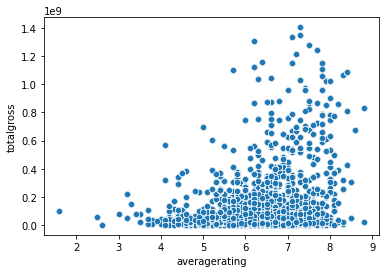

In [79]:
# Plot revenue vs. rating
sns.scatterplot(data=df_clean[has_rev_filter], x='averagerating', y='totalgross' );

**Observations**
- It looks like there is a slight upwards trend
- There seems to be a lot of spread

In [80]:
# We also need to find the correlation coefficient
x = df_clean[has_rev_filter]['totalgross']
y = df_clean[has_rev_filter]['averagerating']
coer_data = np.corrcoef(x, y)
print(f'The correlation coefficient is: {round(coer_data[0,1],4)}')

The correlation coefficient is: 0.2814


In [81]:
# Let's run a simple linear regression model
endog = df_clean[has_rev_filter]['totalgross'] # Revenue is independant
exog = sm.add_constant(df_clean[has_rev_filter]['averagerating']) # Rating is dependant
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit()
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalgross   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2696.
Date:                Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                        13:18:16   Log-Likelihood:            -6.5091e+05
No. Observations:               31354   AIC:                         1.302e+06
Df Residuals:                   31352   BIC:                         1.302e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.078e+08      1e+07    -30.723      0.000   -3.27e+08   -2.88e+08
averagerating   7.87e+07   1.52e+06     51.919      0.000    7.57e+07    8.17e+07
==============================================================================
Omnibus:                    10951.734   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34533.739
Skew:                           1.827   Prob(JB):                         0.00
Kurtosis:                       6.617   Cond. No.                         47.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observations**
- [TBD]